<a href="https://colab.research.google.com/github/Pranesh1306/Pranesh1306/blob/main/Copy_of_UNET_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    image = image / 255.0  # Normalize by dividing by 255
    return image

def preprocess_label(label_path, target_size):
    label = cv2.imread(label_path)
    label = cv2.resize(label, target_size, interpolation=cv2.INTER_NEAREST)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    label = label / 255.0  # Normalize by dividing by 255
    return label

def preprocess_data(image_folder, label_folder, target_size):
    images = []
    labels = []

    image_files = os.listdir(image_folder)
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, image_file)

        image = preprocess_image(image_path, target_size)
        label = preprocess_image(label_path, target_size)

        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [3]:
# Paths to the image and label folders
import zipfile
zip_file_path_1 = "images.zip"
zip_file_path_2 = "labels.zip"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path_1, 'r') as zip_ref:
    zip_ref.extractall('images')  # Extract to the 'images' directory
# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path_2, 'r') as zip_ref:
    zip_ref.extractall('labels')  # Extract to the 'images' directory

In [4]:
image_folder = "/content/images"
label_folder = "/content/labels"

In [5]:
# Preprocess the data
target_size = (256, 256)
images, labels = preprocess_data(image_folder,label_folder, target_size)

In [6]:
np.shape(images)

(220, 256, 256, 3)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3
)
# Convert the tuples to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Reshape the images and labels to match the expected input shape
reshaped_images = images.reshape(-1, target_size[0], target_size[1], 3)
reshaped_labels = labels.reshape(-1, target_size[0], target_size[1], 3)

# Generate augmented images
augmented_images = []
augmented_labels = []
for image in reshaped_images:
    augmented_images.extend(datagen.flow(np.expand_dims(image, axis=0), batch_size=1)[0])
for label in reshaped_labels:
    augmented_labels.extend(datagen.flow(np.expand_dims(label, axis=0), batch_size=1)[0])

# Convert the augmented images back to numpy array format
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [8]:
# Combine original and augmented images for training
combined_images = np.concatenate((images, augmented_images), axis=0)
combined_labels = np.concatenate((labels, augmented_labels), axis=0)

# Convert the combined dataset back to separate arrays
combined_images = np.array(list(combined_images))
combined_labels = np.array(list(combined_labels))

train_images, test_images, train_labels, test_labels = train_test_split(combined_images,combined_labels, test_size=0.2, random_state=42)


<ipython-input-9-03f1e306198d>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


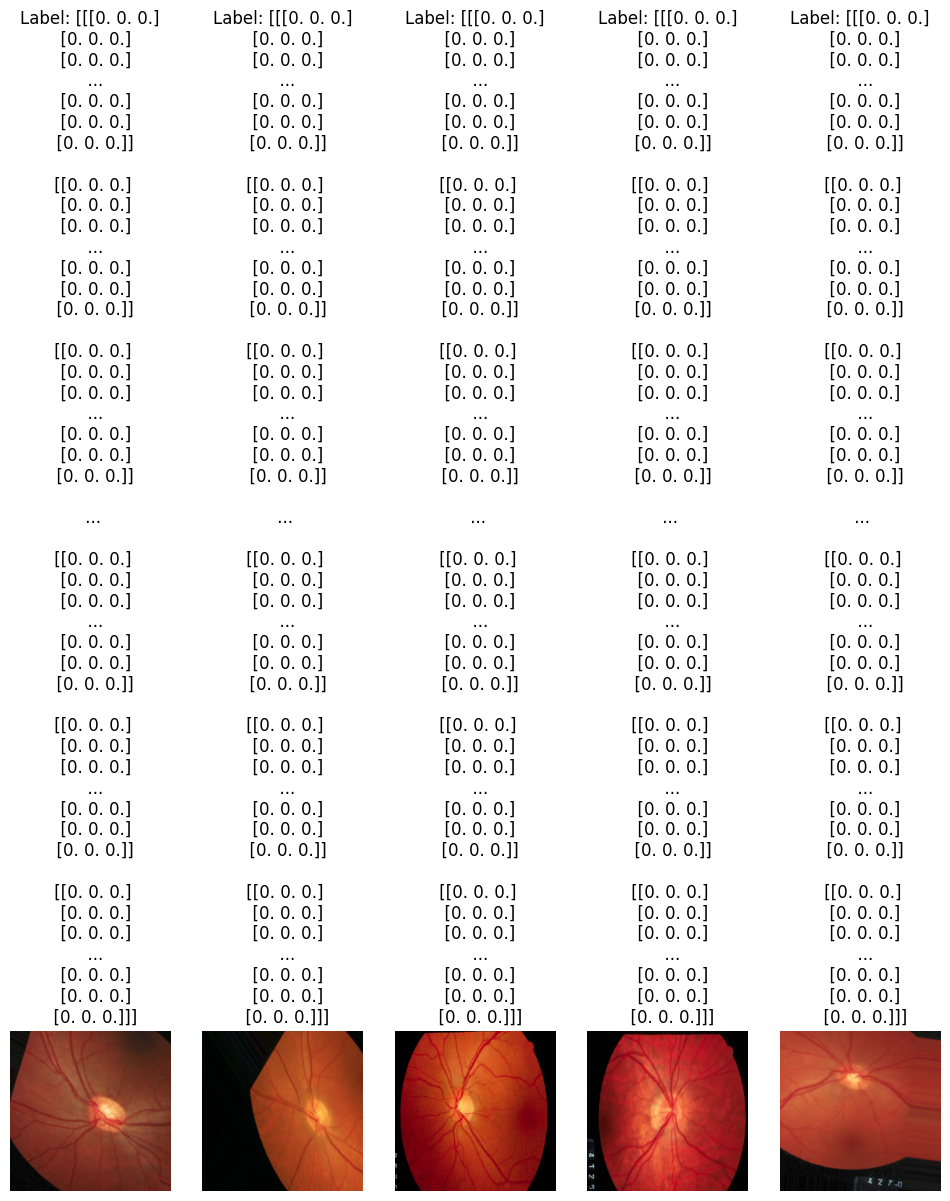

In [9]:
import matplotlib.pyplot as plt

# Display a few images with their labels
num_images = 5  # Number of images to display
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(12, 6))

for i in range(num_images):
    # Display the image
    axes[i].imshow(train_images[i])  # Assuming train_images contains the input images
    axes[i].axis('off')
    
    # Display the label
    axes[i].set_title(f"Label: {train_labels[i]}")  # Assuming train_labels contains the corresponding labels

plt.tight_layout()
plt.show()

In [10]:
np.shape(train_images)

(352, 256, 256, 3)

In [11]:
!pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.5 MB/s eta 0:00:00


In [13]:
!pip install tensorflow --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications.efficientnet import EfficientNetB0  # Updated import statement

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)
    efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)

    s1, p1 = encoder_block(efficientnet.get_layer("block2a_activation").output, 64)  # Updated layer name
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)  # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)

    model = Model(inputs=inputs, outputs=outputs, name="U-Net")
    return model

# Assuming you have defined and initialized resized_train_images and resized_test_images

# Convert labels to single-channel format
train_labels = tf.reduce_max(train_labels, axis=-1, keepdims=True)
test_labels = tf.reduce_max(test_labels, axis=-1, keepdims=True)


# Resize target labels
resized_train_labels = tf.image.resize(train_labels, (64, 64))  # Resize train labels to match the predicted output shape
resized_test_labels = tf.image.resize(test_labels, (64, 64))  # Resize test labels to match the predicted output shape

# Build and compile the UNet model
my_unet = build_unet(input_shape=(256, 256, 3), n_classes=1)
print(my_unet.summary())

# Train the model
batch_size = 16
epochs = 10
my_unet.compile(optimizer=Adam(), loss="binary_crossentropy")
my_unet.fit(
    train_images, resized_train_labels,
    validation_data=(test_images, resized_test_labels),
    batch_size=batch_size,
    epochs=epochs
)


16705208/16705208 [==============================] - 2s 0us/step
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)     

In [15]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import tensorflow as tf
# Make predictions on the test set
predictions = my_unet.predict(test_images)


3/3 [==============================] - 4s 895ms/step


In [17]:
from skimage.transform import resize

# Rescale y_pred to match y_true
rescaled_predictions = []
for image in predictions:
    rescaled_image = resize(image, (256, 256), mode='constant', preserve_range=True)
    rescaled_predictions.append(rescaled_image)
rescaled_predictions = np.array(rescaled_predictions)

# Calculate metrics
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_specificity(y_true, y_pred):
    true_negative = np.sum((1 - y_true) * (1 - y_pred))
    true_negative_rate = true_negative / np.sum(1 - y_true)
    return true_negative_rate

def calculate_sensitivity(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    true_positive_rate = true_positive / np.sum(y_true)
    return true_positive_rate

# Calculate metrics
iou = calculate_iou(test_labels, rescaled_predictions)
specificity = calculate_specificity(test_labels, rescaled_predictions)
sensitivity = calculate_sensitivity(test_labels, rescaled_predictions)

# Calculate accuracy using confusion matrix
true_labels = np.argmax(test_labels, axis=3)
predicted_labels = np.argmax(rescaled_predictions, axis=3)
cm = confusion_matrix(true_labels.ravel(), predicted_labels.ravel())
accuracy = np.trace(cm) / np.sum(cm)
print("Confusion Matrix:")
print(cm)

print("True Labels:")
print(true_labels.ravel())

print("Predicted Labels:")
print(predicted_labels.ravel())

print("Accuracy:", accuracy)
print("IOU:", iou)
print("Specificity:", specificity)
print("Sensitivity:", sensitivity)


Confusion Matrix:
[[5767168]]
True Labels:
[0 0 0 ... 0 0 0]
Predicted Labels:
[0 0 0 ... 0 0 0]
Accuracy: 1.0
IOU: 0.03618985956365412
Specificity: 0.9161758613224709
Sensitivity: 0.11203443472561085


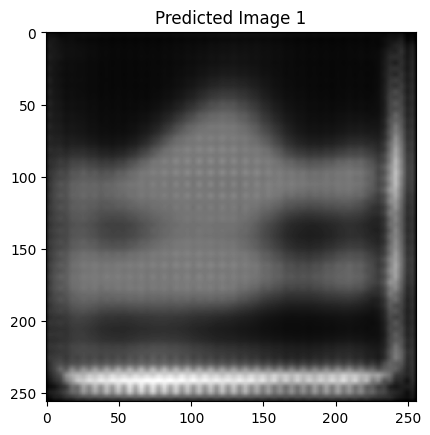

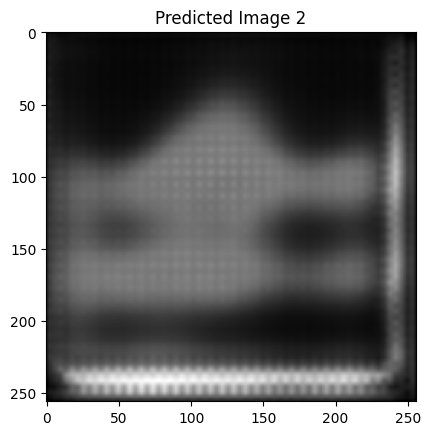

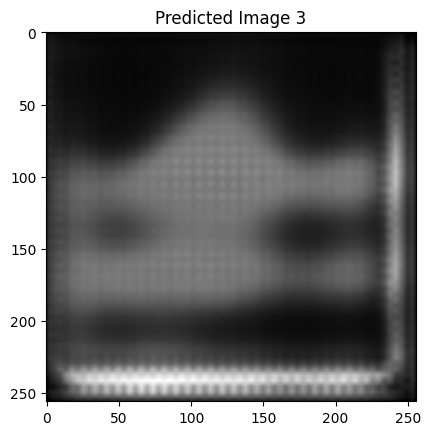

In [20]:
for i in range(3):  # Change the number to the desired number of images
    plt.imshow(rescaled_predictions[i], cmap='gray')  # Assuming grayscale images
    plt.title("Predicted Image {}".format(i+1))
    plt.show()

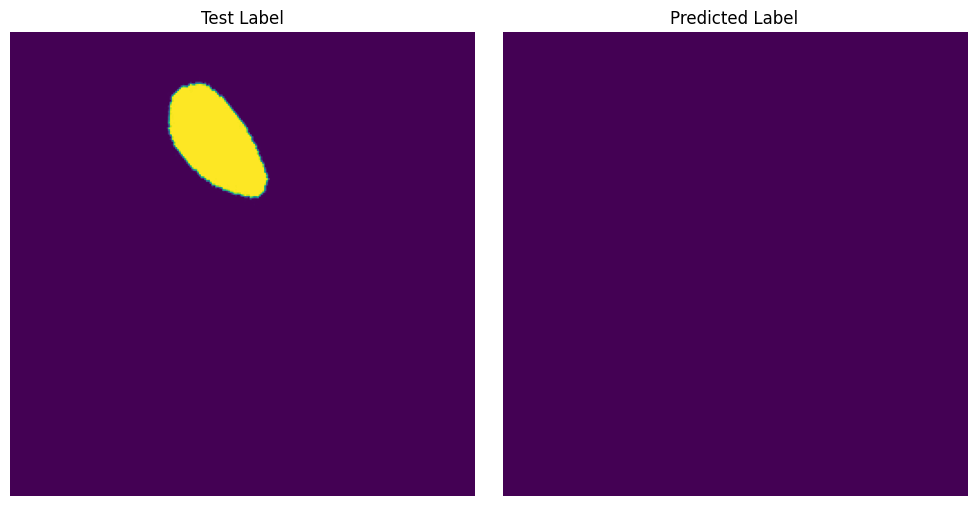

In [21]:
import matplotlib.pyplot as plt

# Assuming test_labels and predicted_labels are NumPy arrays containing two images

# Adjust the figure size
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the test label
axes[0].imshow(test_labels[0])
axes[0].set_title("Test Label")
axes[0].axis('off')

# Display the predicted label
axes[1].imshow(predicted_labels[0])
axes[1].set_title("Predicted Label")
axes[1].axis('off')

plt.tight_layout()
plt.show()
